# Module 3B: Statistical properties of time series Data - Nonstationarity and Unit Roots

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.formula.api as smf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.tools import diff
from arch.unitroot import ADF, PhillipsPerron, KPSS
from pmdarima.arima import auto_arima


from utils_statsmodels import adf_test, bglm_test, aic_eviews, bic_eviews, aic_lectures, bic_lectures

## Identifying Non-Stationarity

Before starting with the exercises, let's tackle the optional idea of exploring the random disturbances provided in the lectures and generating non-stationary series:

In [2]:
df1 = pd.read_csv(
    "data/module3b_data_Simulated_Nonstationary.CSV", 
    index_col='dateid01', parse_dates=True, 
    usecols=['dateid01', 'em', 'en', 'm', 'n'])

df1

,em,en,m,n
dateid01,,,,
1973-07-01,0.000000,0.000000,0.0,0
1973-08-01,0.211908,-1.455569,1.5,-2
1973-09-01,1.633812,0.379432,3.0,-4
1973-10-01,2.398119,0.342120,4.5,-6
1973-11-01,-0.023755,-1.083531,6.0,-8
...,...,...,...,...
2014-10-01,-1.926201,1.043402,742.5,-990
2014-11-01,-0.294635,-0.620686,744.0,-992
2014-12-01,-1.132285,-1.115311,745.5,-994


Just by looking at the values, we can see that `m` increases 1.5 each period and `n` decrases by -2 each period. `em` and `en` look like random noises.



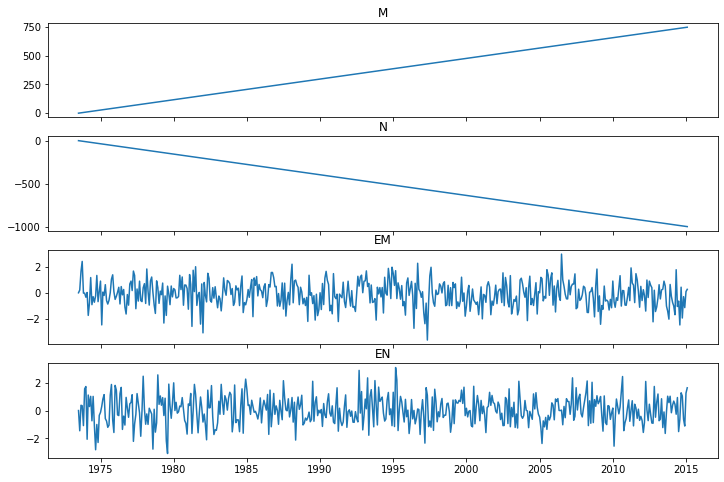

In [3]:
fig, ax = plt.subplots(4, 1, figsize=(12, 8), sharex='col')

ax[0].plot(df1.m)
ax[0].set_title('M')
ax[1].plot(df1.n)
ax[1].set_title('N')
ax[2].plot(df1.em)
ax[2].set_title('EM')
ax[3].plot(df1.en)
ax[3].set_title('EN');

I don't know exactly why they provided the `n` and `m` series, but below is the code to reproduce the equations and plot them. The series are clearly non-stationary.

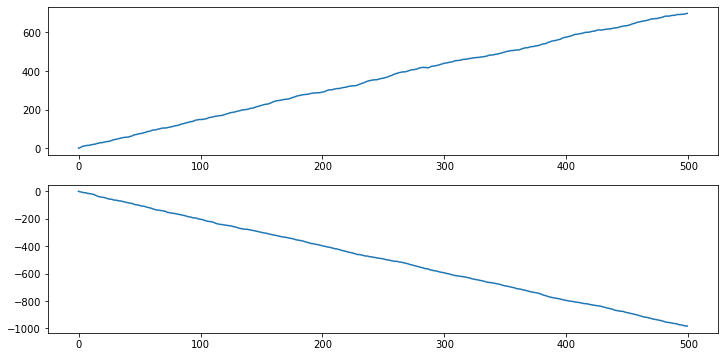

In [4]:
size = len(df1.em)
m1 = np.zeros(size)
n1 = np.zeros(size)

for i in range(size - 1):
    m1[i+1] = 1.5 + m1[i] + df1.em.values[i+1]
    n1[i+1] = -2 + n1[i] + df1.en.values[i+1]

fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].plot(m1)
ax[1].plot(n1);

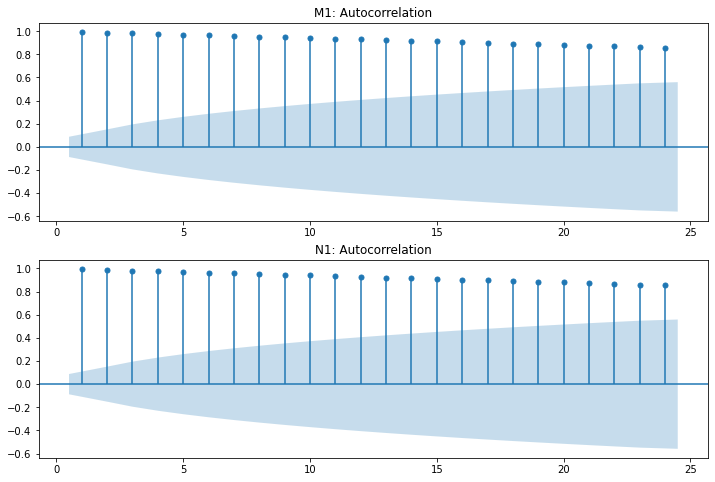

In [5]:
fig, ax = plt.subplots(2, 1, figsize=(12, 8))

plot_acf(m1, ax=ax[0], lags=range(1, 25), title = 'M1: Autocorrelation')
plot_acf(n1, ax=ax[1], lags=range(1, 25), title = 'N1: Autocorrelation');

In [6]:
SARIMAX(m1, order=(1, 0, 0), trend='c').fit(disp=0).params

array([0.00421099, 0.99998794, 2.94148426])

In [7]:
SARIMAX(n1, order=(1, 0, 0), trend='c').fit(disp=0).params

array([-0.00503186,  0.99998977,  4.91315977])

In [8]:
_ = pd.DataFrame({'n': n1, 'm': m1})
spurious = smf.ols('m ~ n', data=_).fit()
spurious.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      m   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 5.330e+05
Date:                Wed, 20 Oct 2021   Prob (F-statistic):               0.00
Time:                        07:58:19   Log-Likelihood:                -1623.9
No. Observations:                 500   AIC:                             3252.
Df Residuals:                     498   BIC:                             3260.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.6886      0.562      6.559      0.000       2.584       4.794
n             -0.7202      0.001   -730.065      0.000      -0.722      -0.718
==============================================================================
Omnibus:                       30.518   Durbin-Watson:                   0.040
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               34.977
Skew:                           0.648   Prob(JB):                     2.54e-08
Kurtosis:                       3.022   Cond. No.                     1.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

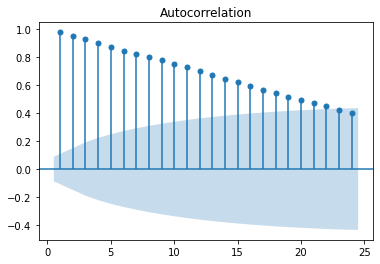

In [9]:
plot_acf(spurious.resid, lags=range(1, 25));

For curiosity, let's repeat the same exercise with "near-unit-roots"

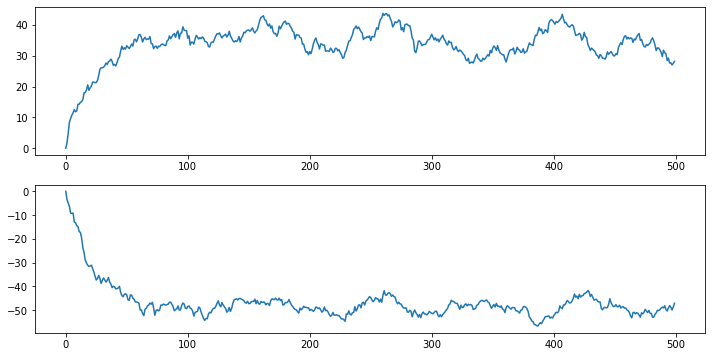

In [10]:
size = len(df1.em)
m2 = np.zeros(size)
n2 = np.zeros(size)

for i in range(size - 1):
    m2[i+1] = 1.5 + 0.96*m2[i] + df1.em.values[i+1]
    n2[i+1] = -2 + 0.96*n2[i] + df1.en.values[i+1]

fig, ax = plt.subplots(2, 1, figsize=(12, 6))
ax[0].plot(m2)
ax[1].plot(n2);

In [11]:
_ = pd.DataFrame({'n': n2, 'm': m2})
_ = _.assign(dm=_.m - _.m.shift(1), dn=_.n - _.n.shift(1))
spurious = smf.ols('m ~ n', data=_).fit()
spurious.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      m   R-squared:                       0.529
Model:                            OLS   Adj. R-squared:                  0.528
Method:                 Least Squares   F-statistic:                     558.7
Date:                Wed, 20 Oct 2021   Prob (F-statistic):           2.16e-83
Time:                        07:58:22   Log-Likelihood:                -1420.6
No. Observations:                 500   AIC:                             2845.
Df Residuals:                     498   BIC:                             2854.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.2012      1.174      5.283      0.000       3.895       8.507
n             -0.5844      0.025    -23.637      0.000      -0.633      -0.536
==============================================================================
Omnibus:                       22.501   Durbin-Watson:                   0.080
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               24.442
Skew:                           0.528   Prob(JB):                     4.93e-06
Kurtosis:                       2.759   Cond. No.                         300.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [12]:
spurious = smf.ols('dm ~ dn', data=_).fit()
spurious.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     dm   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.206
Date:                Wed, 20 Oct 2021   Prob (F-statistic):              0.273
Time:                        07:58:22   Log-Likelihood:                -719.99
No. Observations:                 499   AIC:                             1444.
Df Residuals:                     497   BIC:                             1452.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0520      0.046      1.128      0.260      -0.039       0.143
dn            -0.0467      0.043     -1.098      0.273      -0.130       0.037
==============================================================================
Omnibus:                        2.260   Durbin-Watson:                   1.902
Prob(Omnibus):                  0.323   Jarque-Bera (JB):                2.065
Skew:                          -0.111   Prob(JB):                        0.356
Kurtosis:                       3.223   Cond. No.                         1.13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Note how near-unit roots also lead to spurious regression.

## Question 3.40

In [13]:
df2 = pd.read_csv(
    "data/module3b_data_PE_ratios.csv", 
    index_col='dateid01', parse_dates=True,
    usecols=['dateid01', 'pe_ind']).dropna()
df2

,pe_ind
dateid01,
2000-01-01,16.4949
2000-02-01,17.2608
2000-03-01,14.4154
2000-04-01,13.4247
2000-05-01,12.7792
...,...
2014-10-01,19.3798
2014-11-01,19.9561
2014-12-01,19.4043


The `statsmodels` module in Python provide the ADF and the KPSS tests through the functions `adfuller()` and `kpss()`. However, the output of these functions is cryptic, so I think it's just easier to load the `arch` module and import the unit root tests from there. As another advantage, the `arch` module also provides a Phillips Perron test.

This session of the course in the lectures and questions are really confusing so please just read the questions and try to answer them based on the figures displayed there. Here you will find the code to undertake similar calculations using python.

In [14]:
from statsmodels.tsa.stattools import adfuller, kpss
from arch.unitroot import ADF, PhillipsPerron, KPSS

print(ADF(df2['pe_ind'], trend='ct'))

print('\n')

print(ADF(df2['pe_ind'], trend='c'))

   Augmented Dickey-Fuller Results   
Test Statistic                 -2.957
P-value                         0.145
Lags                                0
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.01 (1%), -3.44 (5%), -3.14 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


   Augmented Dickey-Fuller Results   
Test Statistic                 -2.806
P-value                         0.057
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


Note that the Phillips-Perron test here fails to reject the null at 10% when we add a trend, which suggests that the series is non-stationary. This value is different from the value presented by EViews.

In [15]:
from arch.unitroot import PhillipsPerron

print(PhillipsPerron(df2['pe_ind'], trend='ct'))

print('\n')

print(PhillipsPerron(df2['pe_ind'], trend='c'))



     Phillips-Perron Test (Z-tau)    
Test Statistic                 -3.107
P-value                         0.104
Lags                               14
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -4.01 (1%), -3.44 (5%), -3.14 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


     Phillips-Perron Test (Z-tau)    
Test Statistic                 -2.956
P-value                         0.039
Lags                               14
-------------------------------------

Trend: Constant
Critical Values: -3.47 (1%), -2.88 (5%), -2.58 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


## Question 3.41

However, the KPSS test (the most powerful), fails to reject the null of stationarity, so we can conclude that the series is stationary after all.

In [16]:
print(KPSS(df2['pe_ind'], trend='c'))

print('\n')

print(KPSS(df2['pe_ind'], trend='ct'))

    KPSS Stationarity Test Results   
Test Statistic                  0.296
P-value                         0.139
Lags                                8
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


    KPSS Stationarity Test Results   
Test Statistic                  0.101
P-value                         0.159
Lags                                8
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


## Question 3.42

Load the dataset

In [17]:
df3 = pd.read_csv(
    "data/module3b_data_Simulated_full_sample.csv", 
    index_col='dateid01', parse_dates=True, 
    usecols=['dateid01', 'x', 'y', 'z'])

df3

,x,y,z
dateid01,,,
1900-01-01,0.000000,0.000000,0.000000
1900-02-01,2.644404,-0.723371,2.538293
1900-03-01,3.439934,2.142096,2.227375
1900-04-01,3.615788,4.493112,4.767550
1900-05-01,4.764565,5.088569,4.051969
...,...,...,...
2014-10-01,57.927184,12.300767,1101.367962
2014-11-01,59.023608,12.723256,1099.280487
2014-12-01,56.303902,12.958931,1101.719133


For the first difference of z, do the ADF or PP tests fail to reject the null hypothesis of a unit root for any of the specifications (constant/constant and trend)?

I'm loading the helper function `diff()` from statstools that takes the first difference of the series, to save time, but it would be easy to write a function to do it.

In [18]:
print(ADF(diff(df3['z'], 1), trend='c'))

print('\n')

print(ADF(diff(df3['z'], 1), trend='ct'))

   Augmented Dickey-Fuller Results   
Test Statistic                -37.262
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


   Augmented Dickey-Fuller Results   
Test Statistic                -37.251
P-value                         0.000
Lags                                0
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.97 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [19]:
print(PhillipsPerron(diff(df3['z'], 1), trend='c'))

print('\n')

print(PhillipsPerron(diff(df3['z'], 1), trend='ct'))

     Phillips-Perron Test (Z-tau)    
Test Statistic                -37.338
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant
Critical Values: -3.44 (1%), -2.86 (5%), -2.57 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


     Phillips-Perron Test (Z-tau)    
Test Statistic                -37.326
P-value                         0.000
Lags                               24
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: -3.97 (1%), -3.41 (5%), -3.13 (10%)
Null Hypothesis: The process contains a unit root.
Alternative Hypothesis: The process is weakly stationary.


In [20]:
print(KPSS(diff(df3['z'], 1), trend='c'))

print('\n')

print(KPSS(diff(df3['z'], 1), trend='ct'))

    KPSS Stationarity Test Results   
Test Statistic                  0.040
P-value                         0.936
Lags                                4
-------------------------------------

Trend: Constant
Critical Values: 0.74 (1%), 0.46 (5%), 0.35 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


    KPSS Stationarity Test Results   
Test Statistic                  0.036
P-value                         0.786
Lags                                4
-------------------------------------

Trend: Constant and Linear Time Trend
Critical Values: 0.22 (1%), 0.15 (5%), 0.12 (10%)
Null Hypothesis: The process is weakly stationary.
Alternative Hypothesis: The process contains a unit root.


I'll leave the optional questions to the reader.

Open the series “pe_aus”, the price-earnings ratio for Australia. For the sample period 2000M4 - 2015M2, conduct the three unit root/stationarity tests covered in the lecture (ADF, PP, and KPSS) for all specifications (Intercept, Intercept and Trend, and None), using the AIC to determine the maximum lag included.

In [21]:
df4 = pd.read_csv(
    "data/module3b_data_PE_ratios.csv", 
    index_col='dateid01', parse_dates=True,
    usecols=['dateid01', 'pe_aus']).dropna()
df4

,pe_aus
dateid01,
2000-04-01,22.0339
2000-05-01,22.4678
2000-06-01,19.1747
2000-07-01,19.2828
2000-08-01,19.5004
...,...
2014-10-01,18.7117
2014-11-01,18.0667
2014-12-01,19.9690


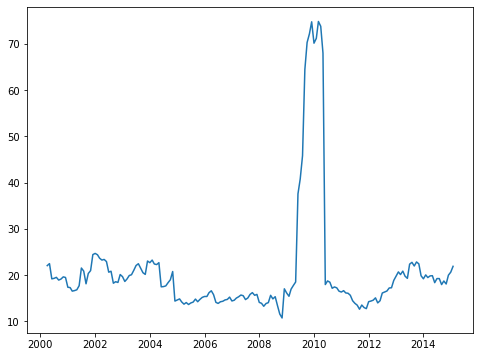

In [22]:
# Always plot the data!

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(df4.pe_aus);

That's quite a spike around 2010 after the GFC!

## Question 3.44

In `statsmodels` you cannot recover the coefficients of the regressions that led to the unit-root tests. Nonetheless, we can infer that the best model is the one that leads to the lowest p-value for the ADF/PP test and the highest for the KPSS test.

In [23]:
print('ADF Test\n')
for i in ['n', 'c', 'ct']:
    print(f'Trend: {i} --> p-value: {ADF(df4.pe_aus, trend=i).pvalue}\n')

print('PP Test\n')
for i in ['n', 'c', 'ct']:
    print(f'Trend: {i} --> p-value: {PhillipsPerron(df4.pe_aus, trend=i).pvalue}\n')

print('KPSS Test\n')
for i in ['c', 'ct']:
    print(f'Trend: {i} --> p-value: {KPSS(df4.pe_aus, trend=i).pvalue}\n')
    


ADF Test

Trend: n --> p-value: 0.13559791887820688

Trend: c --> p-value: 0.0007664687956573181

Trend: ct --> p-value: 0.0049030772280503

PP Test

Trend: n --> p-value: 0.14895639219134393

Trend: c --> p-value: 0.046995847303445124

Trend: ct --> p-value: 0.16357260597005213

KPSS Test

Trend: c --> p-value: 0.5836176703075863

Trend: ct --> p-value: 0.3141215427218798



The model with only a constant leads to the lowest p-value. We can guess that adding a constant leads to the best model.

## Question 3.45
With a p-value of 0.0007, we can clearly reject the null of non-stationarity.

## Question 3.46

As we saw when we plotted the figure, if there's a structural break it is between 2008 and 2010.

**Pre-crisis tests:**

Repeat the unit root/stationarity tests, for the pre-Global Crisis period (from 2000:04 to 2009:05).





<AxesSubplot:xlabel='dateid01'>

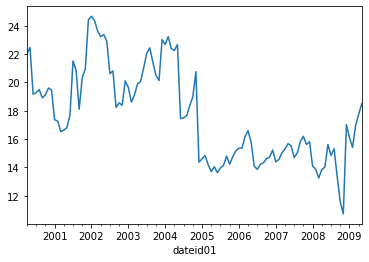

In [24]:
series = df4.pe_aus.loc[:'2009-05-01']
series.plot()

## Question 3.48

In [25]:
print('ADF Test\n')
for i in ['n', 'c', 'ct']:
    print(f'Trend: {i} --> p-value: {ADF(series, trend=i).pvalue}\n')

print('PP Test\n')
for i in ['n', 'c', 'ct']:
    print(f'Trend: {i} --> p-value: {PhillipsPerron(series, trend=i).pvalue}\n')

print('KPSS Test\n')
for i in ['c', 'ct']:
    print(f'Trend: {i} --> p-value: {KPSS(series, trend=i).pvalue}\n')

ADF Test

Trend: n --> p-value: 0.41890522140869857

Trend: c --> p-value: 0.10312919227895218

Trend: ct --> p-value: 0.1395248383968356

PP Test

Trend: n --> p-value: 0.42620035411031865

Trend: c --> p-value: 0.10202742194591263

Trend: ct --> p-value: 0.10510142993262378

KPSS Test

Trend: c --> p-value: 0.0008023531327082209

Trend: ct --> p-value: 0.061913510073644075



Conflicting results.

## Question 3.49

Where is the structural break?

According to `statsmodels` `zivot_andrews()` function, it is on "2009-05-01". According to R's `ur.za()` from the `urca` package it is on "2010-05-01". EViews says that the breakpoint is on "2009-04-01" and EViews marks as the breakpoint the first period AFTER the break so the results are not the same..

In [33]:
from arch.unitroot import ZivotAndrews
from statsmodels.tsa.stattools import zivot_andrews

_, pval, _, _, idx = zivot_andrews(df4.pe_aus, regression='ct')

print(f'p-value: {pval}\n')

print(f'Break point: {df4.iloc[idx].name.strftime("%Y-%m-%d")}')

p-value: 0.0035059045301762794

Break point: 2009-05-01


## Question 3.50

Results are not shared across platforms because different implementations of ZivotAndrews test are used.

## Question 3.51

## Question 3.52

## Question 3.53

These questions can't be answered without using EViews since they rely on EViews particular implementation.

Lastly, please return to the three standard (i.e., non break point) unit tests that we started with in this question set. Calculate the three unit root/stationarity tests for just the post-Global Crisis period (i.e., 2010:12 – 2015:02).

<AxesSubplot:xlabel='dateid01'>

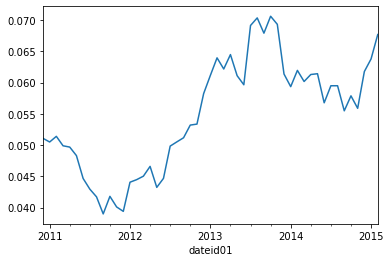

In [35]:
series = df4.pe_aus.loc['2010-12-01':]
series.plot()

## Question 3.54

Which of the specifications is most appropriate?

In [36]:
print('ADF Test\n')
for i in ['n', 'c', 'ct']:
    print(f'Trend: {i} --> p-value: {ADF(series, trend=i).pvalue}\n')

print('PP Test\n')
for i in ['n', 'c', 'ct']:
    print(f'Trend: {i} --> p-value: {PhillipsPerron(series, trend=i).pvalue}\n')

print('KPSS Test\n')
for i in ['c', 'ct']:
    print(f'Trend: {i} --> p-value: {KPSS(series, trend=i).pvalue}\n')

ADF Test

Trend: n --> p-value: 0.851991733322607

Trend: c --> p-value: 0.8196478095106003

Trend: ct --> p-value: 0.6208211709741944

PP Test

Trend: n --> p-value: 0.840490189228259

Trend: c --> p-value: 0.7589630392889103

Trend: ct --> p-value: 0.4860785936337114

KPSS Test

Trend: c --> p-value: 0.009408242036279461

Trend: ct --> p-value: 0.07121321813260892



The results are not conclusive.